# 0. Setting Up The Env.

## 0.1 Import Packages

In [44]:
from pathlib import Path

In [45]:
import numpy as np
import pandas as pd

import itertools

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [47]:
from joblib import Parallel, delayed
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

## 0.2 Utilities

In [49]:
def drop_highly_correlated(X: pd.DataFrame, y: pd.Series, threshold: float = 0.65):
    # Absolute correlation among X columns
    corr = X.corr().abs()

    # Correlation of each feature with y
    corr_with_y = X.apply(lambda col: col.corr(y)).abs()

    to_drop = set()
    cols = X.columns

    # Traverse only upper triangle (excluding diagonal)
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            col1, col2 = cols[i], cols[j]
            val = corr.loc[col1, col2]

            if val > threshold:
                # Compare their correlation with y
                corr1, corr2 = corr_with_y[col1], corr_with_y[col2]
                if corr1 >= corr2:
                    drop_col = col2
                else:
                    drop_col = col1

                # Skip if already dropped
                if drop_col not in to_drop:
                    print(f"{col1} ↔ {col2} | corr={val:.3f} | drop={drop_col}")
                    to_drop.add(drop_col)

    print(f"\nColumns to drop ({len(to_drop)}): {sorted(to_drop)}")
    X_reduced = X.drop(columns=list(to_drop))
    return X_reduced, list(to_drop)

In [50]:
def calculate_vif_for_column(X, i):
    """Compute VIF for a single column (for joblib parallelism)."""
    try:
        return variance_inflation_factor(X.values, i)
    except Exception:
        return np.nan  # in case of perfect multicollinearity

def drop_high_vif_features(X: pd.DataFrame, threshold: float = 6.5, n_jobs: int = -1):
    """
    Iteratively drops features with VIF above the threshold.
    Uses joblib to parallelize VIF computation.
    """
    X_curr = X.copy()
    iteration = 1

    while True:
        # Compute VIFs in parallel
        vifs = Parallel(n_jobs=n_jobs)(
            delayed(calculate_vif_for_column)(X_curr, i)
            for i in range(X_curr.shape[1])
        )
        vif_df = pd.DataFrame({'feature': X_curr.columns, 'VIF': vifs})

        max_vif = vif_df['VIF'].max()
        max_col = vif_df.loc[vif_df['VIF'].idxmax(), 'feature']

        print(f"\nIteration {iteration}:")
        # print(vif_df.sort_values('VIF', ascending=False).reset_index(drop=True))

        if max_vif <= threshold:
            print(f"\n All VIFs ≤ {threshold}. Stopping.")
            break

        # Drop the feature with highest VIF
        print(f"Dropping '{max_col}' (VIF = {max_vif:.2f})")
        X_curr = X_curr.drop(columns=[max_col])
        iteration += 1

    return X_curr, vif_df

In [80]:
def plot_features(df, features, y, plot_type='histplot'):
    """
    Plots each feature against the target variable using Seaborn.

    Parameters:
    df (pd.DataFrame): The dataframe.
    features (list): List of feature column names to plot.
    y (str): Target column name.
    plot_type (str): 'histplot', 'boxplot', or 'scatterplot'
    """
    for col in features:
        plt.figure(figsize=(6, 4))
        if plot_type == 'histplot':
            sns.histplot(data=df, x=col, hue=y, kde=True, multiple='stack')
        elif plot_type == 'boxplot':
            sns.boxplot(data=df, x=y, y=col)
        elif plot_type == 'scatterplot':
            sns.scatterplot(data=df, x=col, y=y, hue=y)
        else:
            raise ValueError("plot_type must be 'histplot', 'boxplot', or 'scatterplot'")
        
        plt.title(f"{col} vs {y}")
        plt.tight_layout()
        plt.show()
    return None


## 0.3 Constants

In [52]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [53]:
capped_file_path = f"{project_root}/data/processed/capped_2.csv"
target_file_path = f"{project_root}/data/processed/target_2.csv"
capped_file_path, target_file_path

('d:\\01 Work\\06-Segmentations/data/processed/capped_2.csv',
 'd:\\01 Work\\06-Segmentations/data/processed/target_2.csv')

# 1. The Data

In [54]:
data_df  = pd.read_csv(capped_file_path)
print(f"The data has {data_df.shape[0]} rows and {data_df.shape[1]} columns")
print("Data Preview:")
data_df.head()

The data has 3811 rows and 42 columns
Data Preview:


,age,housing,loan,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,poutcome_failure,poutcome_nonexistent,poutcome_success,contact_cellular,contact_telephone
0,30,1,0,487.0,2,999,0,-1.8,92.893,-46.2,...,1,0,0,0,0,0,1,0,1,0
1,39,0,0,346.0,4,999,0,1.1,93.994,-36.4,...,0,1,0,0,0,0,1,0,0,1
2,25,1,0,227.0,1,999,0,1.4,94.465,-41.8,...,0,1,0,0,0,0,1,0,0,1
3,47,1,0,58.0,1,999,0,-0.1,93.200,-42.0,...,0,0,0,0,1,0,1,0,1,0
4,32,0,0,128.0,3,999,2,-1.1,94.199,-37.5,...,0,0,0,0,1,1,0,0,1,0


In [55]:
y = pd.read_csv(target_file_path)
print(f"The data has {y.shape[0]} rows and {y.shape[1]} columns")
print("Data Preview:")
y.head()

The data has 3811 rows and 1 columns
Data Preview:


,y
0,0
1,0
2,0
3,0
4,0


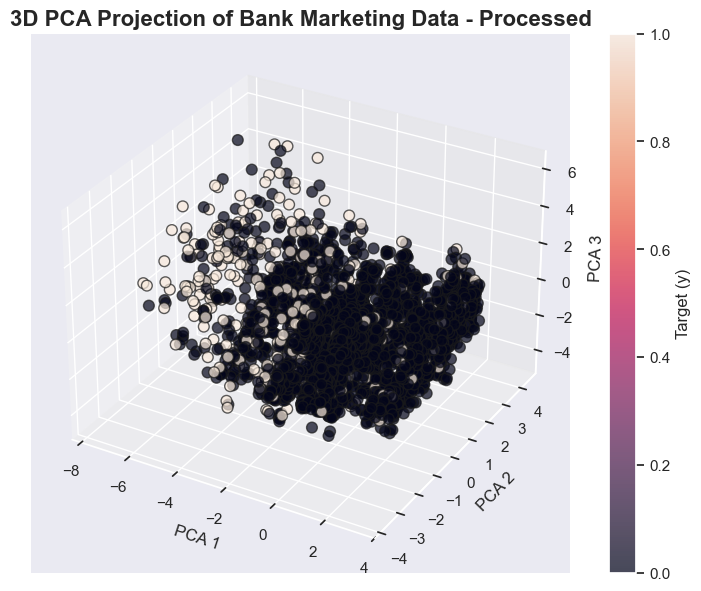

In [56]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(data_df)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scale)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data - Processed", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

# 2. 90% Explainability

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_df)

pca = PCA()
pca.fit(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

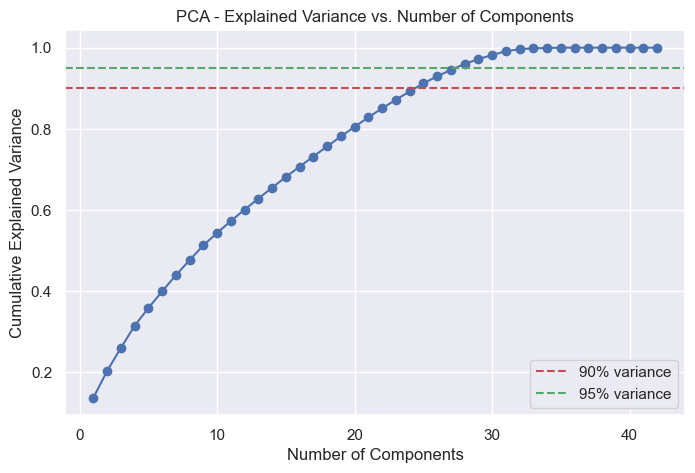

Components to explain 90% variance: 25
Components to explain 95% variance: 28


In [58]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs. Number of Components')
plt.legend()
plt.grid(True)
plt.show()


n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Components to explain 90% variance: {n_components_90}")
print(f"Components to explain 95% variance: {n_components_95}")

In [59]:

n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

loadings = pd.DataFrame(
    pca.components_[:n_components_90].T,
    columns=[f'PC{i+1}' for i in range(n_components_90)],
    index=data_df.select_dtypes(include=[np.number]).columns
)

weighted_var = pca.explained_variance_ratio_[:n_components_90]
feature_importance = (loadings**2).dot(weighted_var)
feature_importance = feature_importance / feature_importance.sum()

top_n = 25
top_features = feature_importance.sort_values(ascending=False).head(top_n)

print(f"Top {top_n} features contributing to variance:")
print(top_features)



Top 25 features contributing to variance:
loan                    0.026706
job_unemployed          0.026659
sin_day_of_week         0.026634
cos_day_of_week         0.026559
duration                0.026556
campaign                0.026536
housing                 0.026532
marital_married         0.026504
poutcome_failure        0.026486
poutcome_nonexistent    0.026282
job_self-employed       0.026253
emp.var.rate            0.026193
job_entrepreneur        0.026000
euribor3m               0.025934
marital_divorced        0.025827
pdays                   0.025788
poutcome_success        0.025784
education_basic.6y      0.025739
job_housemaid           0.025718
contact_cellular        0.025709
contact_telephone       0.025709
education_basic.9y      0.025578
previous                0.025548
marital_single          0.025323
job_admin.              0.024722
dtype: float64


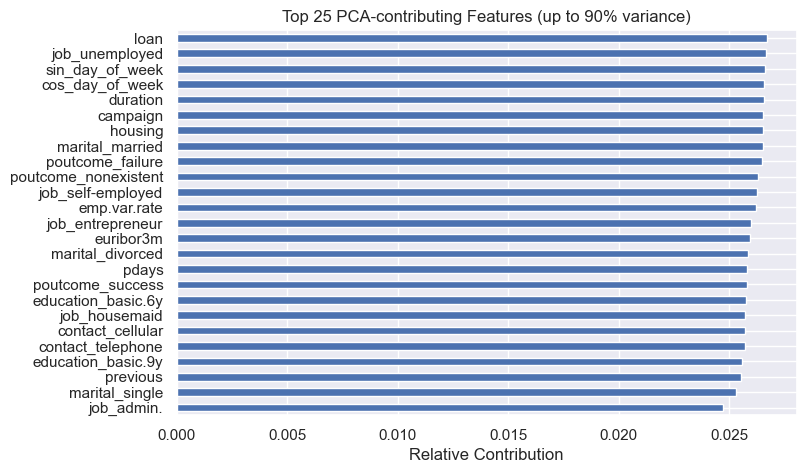

In [60]:
top_features.sort_values().plot(kind='barh', figsize=(8,5))
plt.title(f"Top {top_n} PCA-contributing Features (up to 90% variance)")
plt.xlabel("Relative Contribution")
plt.show()

In [61]:
list(top_features.reset_index()["index"])

['loan',
 'job_unemployed',
 'sin_day_of_week',
 'cos_day_of_week',
 'duration',
 'campaign',
 'housing',
 'marital_married',
 'poutcome_failure',
 'poutcome_nonexistent',
 'job_self-employed',
 'emp.var.rate',
 'job_entrepreneur',
 'euribor3m',
 'marital_divorced',
 'pdays',
 'poutcome_success',
 'education_basic.6y',
 'job_housemaid',
 'contact_cellular',
 'contact_telephone',
 'education_basic.9y',
 'previous',
 'marital_single',
 'job_admin.']

In [62]:
data_90 = data_df[[col for col in top_features.reset_index()["index"]]]
print(data_90.shape)
data_90.head()

(3811, 25)


,loan,job_unemployed,sin_day_of_week,cos_day_of_week,duration,campaign,housing,marital_married,poutcome_failure,poutcome_nonexistent,...,pdays,poutcome_success,education_basic.6y,job_housemaid,contact_cellular,contact_telephone,education_basic.9y,previous,marital_single,job_admin.
0,0,0,-2.449294e-16,1.000000,487.0,2,1,1,0,1,...,999,0,0,0,1,0,1,0,0,0
1,0,0,-2.449294e-16,1.000000,346.0,4,0,0,0,1,...,999,0,0,0,0,1,0,0,1,0
2,0,0,-5.877853e-01,-0.809017,227.0,1,1,1,0,1,...,999,0,0,0,0,1,0,0,0,0
3,0,0,9.510565e-01,0.309017,58.0,1,1,1,0,1,...,999,0,0,0,1,0,0,0,0,1
4,0,0,-9.510565e-01,0.309017,128.0,3,0,0,1,0,...,999,0,0,0,1,0,0,2,1,0


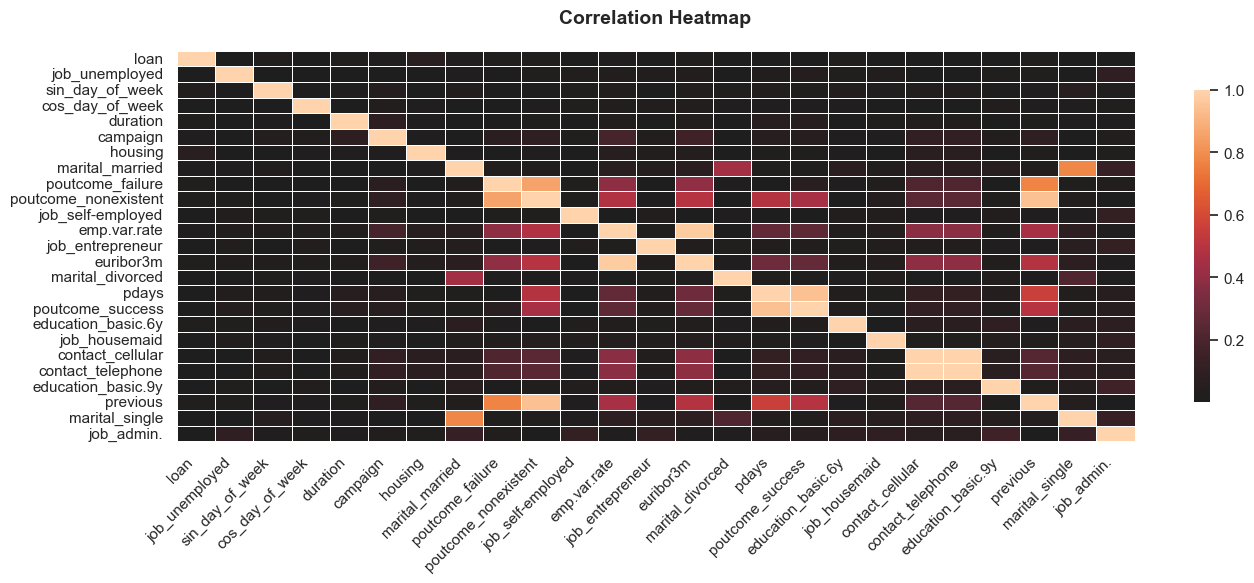

In [63]:
plt.figure(figsize=(14, 6))
corr = data_90.corr().abs()

ax = sns.heatmap(
    corr,
    # annot=True,
    # fmt=".2f",              # format correlations
    center=0,               # center at 0 for diverging colormap
    linewidths=0.5,         # grid lines
    cbar_kws={"shrink": .8} # shrink colorbar for readability
)

ax.set_title("Correlation Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")   # rotate x labels
plt.yticks(rotation=0)                # keep y labels horizontal
plt.tight_layout()
plt.show()

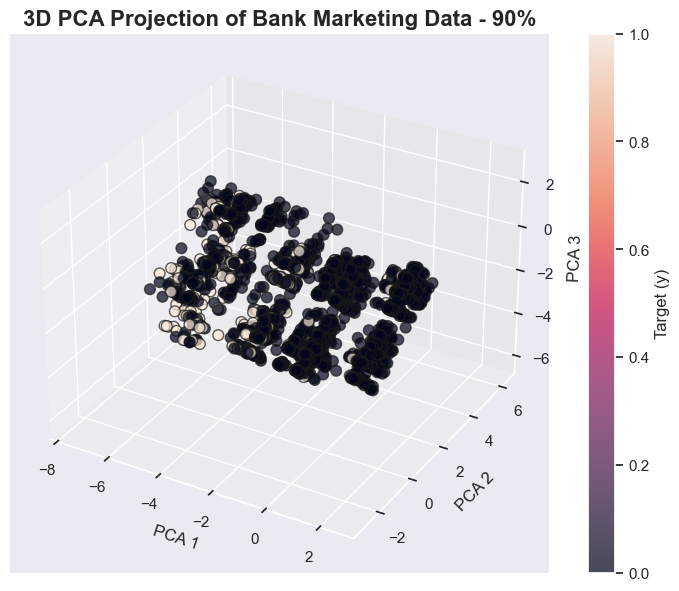

In [64]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(data_90)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scale)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data - 90%", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

# 3. Handle Multi Colinearity

## 3.1 Correlations

In [66]:
X_reduced, dropped_cols = drop_highly_correlated(data_90, y.squeeze(), threshold=0.65)
print(dropped_cols)
X_reduced.shape

marital_married ↔ marital_single | corr=0.780 | drop=marital_married
poutcome_failure ↔ poutcome_nonexistent | corr=0.856 | drop=poutcome_failure
poutcome_nonexistent ↔ previous | corr=0.941 | drop=poutcome_nonexistent
emp.var.rate ↔ euribor3m | corr=0.971 | drop=emp.var.rate
pdays ↔ poutcome_success | corr=0.945 | drop=poutcome_success
contact_cellular ↔ contact_telephone | corr=1.000 | drop=contact_telephone

Columns to drop (6): ['contact_telephone', 'emp.var.rate', 'marital_married', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success']
['contact_telephone', 'poutcome_success', 'poutcome_nonexistent', 'marital_married', 'emp.var.rate', 'poutcome_failure']


(3811, 19)

## 3.2 VIF

In [67]:
X_vif_reduced, final_vif_df = drop_high_vif_features(X_reduced, threshold=6.5)


Iteration 1:
Dropping 'pdays' (VIF = 12.45)

Iteration 2:

 All VIFs ≤ 6.5. Stopping.


In [68]:
final_vif_df

,feature,VIF
0,loan,1.196628
1,job_unemployed,1.039014
2,sin_day_of_week,1.009129
3,cos_day_of_week,1.005324
4,duration,2.037026
5,campaign,2.205280
6,housing,2.094291
7,job_self-employed,1.063604
8,job_entrepreneur,1.063580
9,euribor3m,3.783728


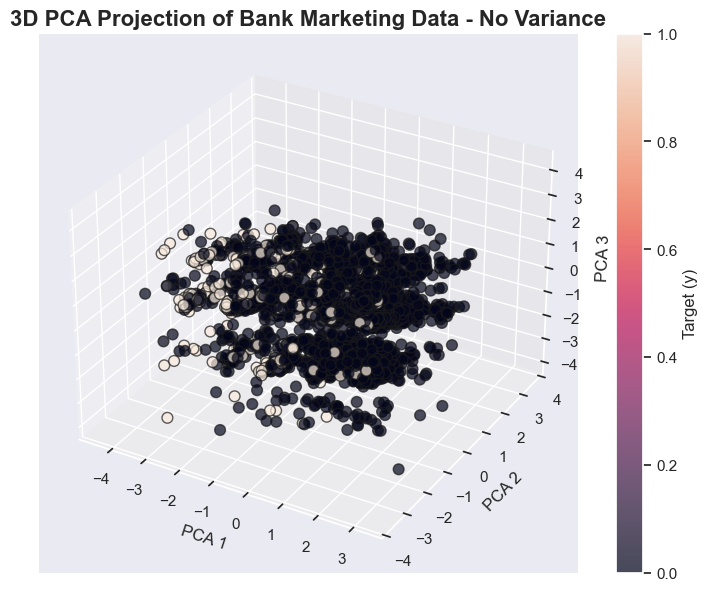

In [69]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_vif_reduced)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scale)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data - No Variance", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

# 4. Business Interpretation

C:\Users\sport\AppData\Local\Temp\ipykernel_15384\743447668.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette="magma")


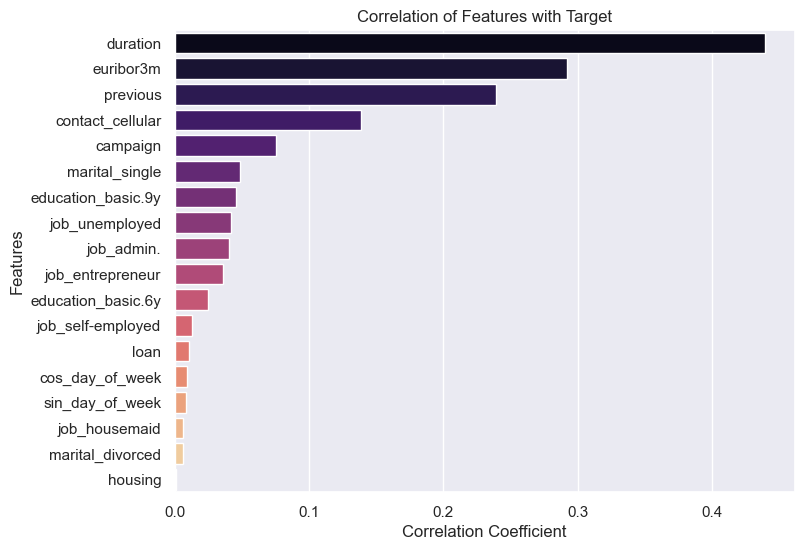

In [70]:
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

# Combine features and target for correlation
df_with_target = X_vif_reduced.copy()
df_with_target['target'] = y.astype(int)  # convert boolean to int for correlation

# Compute correlations
correlations = df_with_target.corr().abs()['target'].drop('target')

# Sort correlations for better visualization
correlations = correlations.sort_values(ascending=False)

# Plot with seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette="magma")
plt.title('Correlation of Features with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [71]:
correlations.reset_index()

,index,target
0,duration,0.439506
1,euribor3m,0.291731
2,previous,0.239049
3,contact_cellular,0.138449
4,campaign,0.075795
5,marital_single,0.048566
6,education_basic.9y,0.045737
7,job_unemployed,0.042330
8,job_admin.,0.040464
9,job_entrepreneur,0.036309


## 4.1 Top 5 feat.

In [72]:
top5_ft = correlations.reset_index()["index"][:5]
top5_ft

0            duration
1           euribor3m
2            previous
3    contact_cellular
4            campaign
Name: index, dtype: object

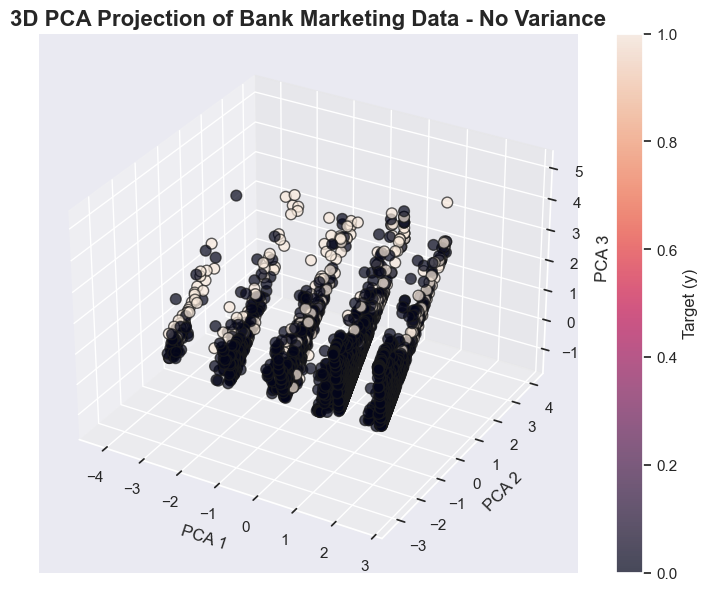

In [73]:
temp = X_vif_reduced[top5_ft]
X_scale = scaler.fit_transform(temp)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scale)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data - No Variance", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

## 4.2 Campaign & Call Info

In [78]:
# Considered Features
cci_ft = [
    # "campaign",
    # "duration", 
    # "contact_telephone",
    "cos_day_of_week",
    "sin_day_of_week"

]


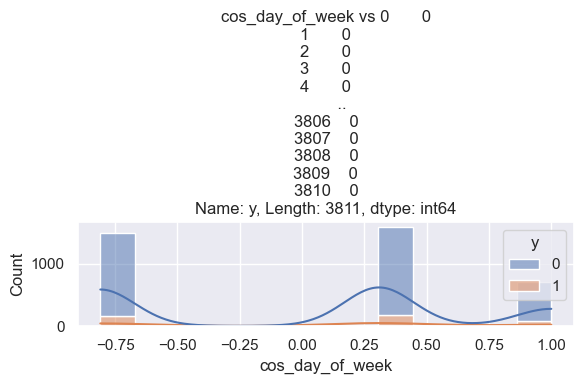

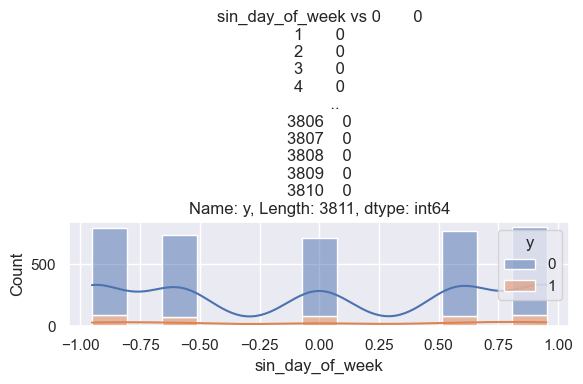

In [84]:
_ = plot_features(X_vif_reduced, cci_ft, y, plot_type='histplot')

* Keeping "cos" for higher correlation with y

In [95]:
req_ft = list(top5_ft)
req_ft.append("cos_day_of_week")
req_ft

['duration',
 'euribor3m',
 'previous',
 'contact_cellular',
 'campaign',
 'cos_day_of_week']

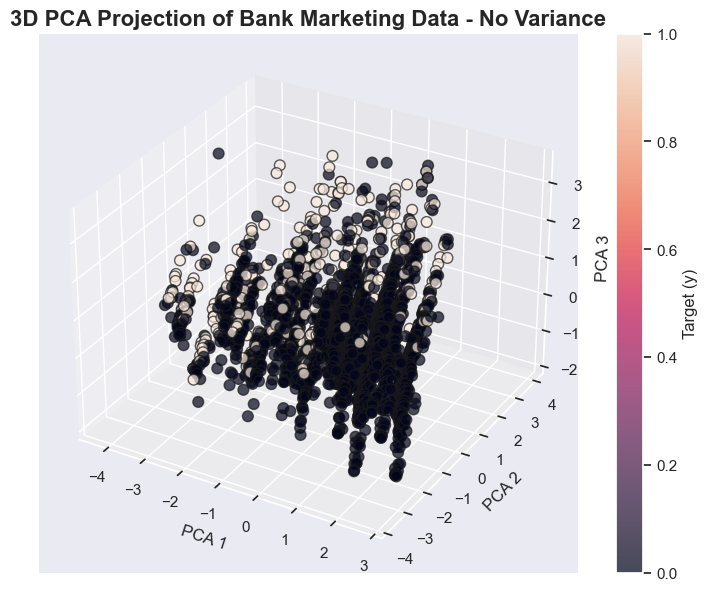

In [96]:
temp = X_vif_reduced[req_ft]
X_scale = scaler.fit_transform(temp)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scale)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data - No Variance", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

## 4.3 Customer Profile

In [101]:
cp_ft = [
    "job_admin.",
    "job_entrepreneur", 
    "job_unemployed", 
    # "job_self-employed", 
    # "job_services", 
    # "job_housemaid", 
    # "job_management", 
    # "job_student", 
    # "job_technician"
]

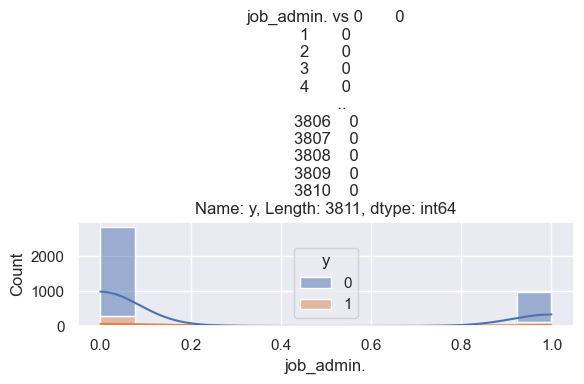

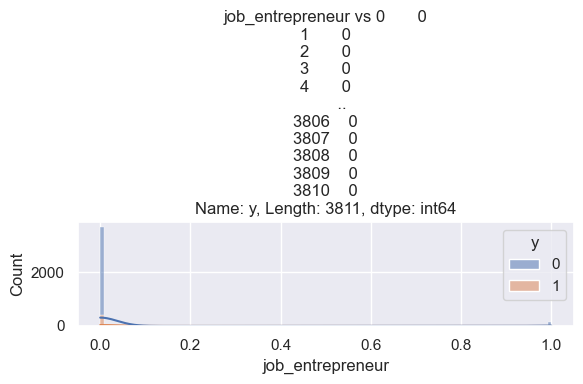

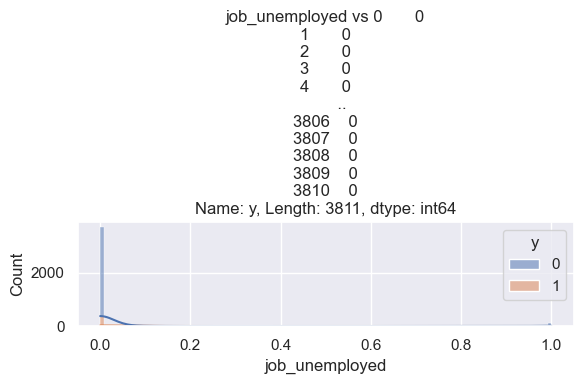

In [102]:
_ = plot_features(X_vif_reduced, cp_ft, y, plot_type='histplot')


In [103]:
req_ft.append("job_admin.")
req_ft

['duration',
 'euribor3m',
 'previous',
 'contact_cellular',
 'campaign',
 'cos_day_of_week',
 'job_admin.']

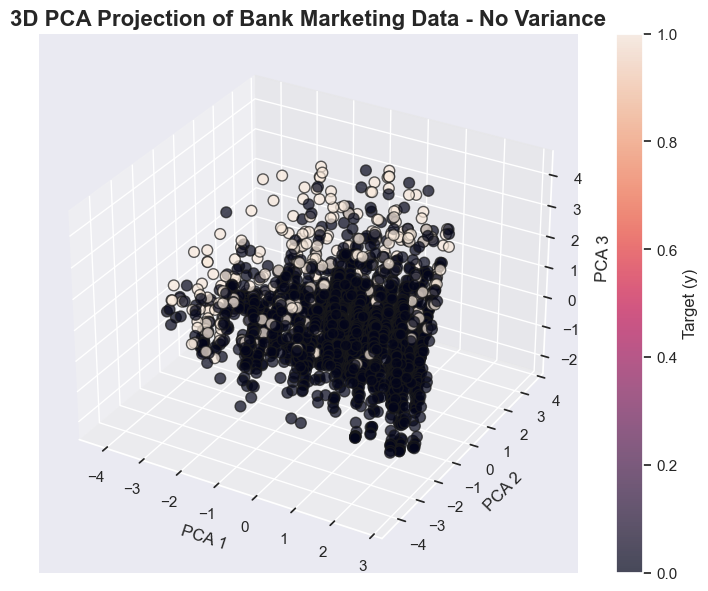

In [104]:
temp = X_vif_reduced[req_ft]
X_scale = scaler.fit_transform(temp)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scale)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data - No Variance", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

## 4.4 Education & Marital

## 4.5 Financial Situation

## 4.6 Campaign Outcome

## 4.7 Month

# END